> ![](https://raw.githubusercontent.com/SunnySuite/Sunny.jl/main/assets/sunny_logo.jpg)
_This is a [tutorial](https://github.com/SunnySuite/SunnyTutorials/tree/main/tutorials)
 for the [Sunny](https://github.com/SunnySuite/Sunny.jl/) package,
 which enables dynamical simulations of ordered and thermally disordered spins with dipole
 and higher order moments._

## Welcome to a Sunny Tutorial on the Diamond Lattice System CoRh<sub>2</sub>O<sub>4</sub>
**Script**: Diamond Lattice Finite Temperature Calculation <br>
**Inspired by**: CoRh<sub>2</sub>O<sub>4</sub> Powder
(Ge _et al._ https://doi.org/10.1103/PhysRevB.96.064413) <br>
**Authors**: Martin Mourigal, David Dahlbom <br>
**Date**: August 21, 2023  (Sunny 0.5.0) <br>
**Goal**: This script is to calculate the temperature dependence of the magnon excitations in the
spin-3/2 Heisenberg Diamond Antiferromagnet and compare to powder-averaged results obtained for
the compound CoRh<sub>2</sub>O<sub>4</sub> <br>

---
#### Loading Packages

In [1]:
using Sunny, GLMakie, ProgressMeter, Statistics, Random, Brillouin
Makie.inline!(true)
Sunny.offline_viewers()
cif_path = joinpath("..", "Sunny.jl", "examples", "longer_examples", "CoRh2O4_#109301.cif");

#### Defining Custom functions

The function `quench!` randomizes the spins of a given `System`, fixes a
target temperature, and lets the system relax at this temperature for `nrelax`
integration steps.

In [2]:
function quench!(sys, integrator; kTtarget, nrelax)
    randomize_spins!(sys);
    integrator.kT = kTtarget;
    prog          = Progress(nrelax; dt=10.0, desc="Quenched and now relaxing: ", color=:green);
    for _ in 1:nrelax
        step!(sys, integrator)
        next!(prog)
    end
end

quench! (generic function with 1 method)

`dwell!` takes a `System`, sets a target temperature, and has the system
dwell at this temperature for `ndwell` integration steps.

In [3]:
function dwell!(sys, integrator; kTtarget, ndwell)
    integrator.kT = kTtarget;
    prog          = Progress(ndwell; dt=10.0, desc="Dwelling: ", color=:green);
    for _ in 1:ndwell
        step!(sys, integrator)
        next!(prog)
    end
end

dwell! (generic function with 1 method)

`anneal!` takes a temperature schedule and cools the `System` through it,
with `ndwell` steps of the integrator at each temperature in the schedule.
Returns the energy at the end of the dwell for each scheduled temperature.

In [4]:
function anneal!(sys,  integrator;  kTschedule, ndwell)
    nspins = prod(size(sys.dipoles));
    ensys  = zeros(length(kTschedule))
    prog   = Progress(ndwell*length(kTschedule); dt=10.0, desc="Annealing: ", color=:red);
    for (i, kT) in enumerate(kTschedule)
        integrator.kT = kT
        for _ in 1:ndwell
            step!(sys, integrator)
            next!(prog)
        end
        ensys[i] = energy(sys)
    end
    return ensys/nspins
end

anneal! (generic function with 1 method)

`sample_sf!` samples a structure factor, which may be either an instant or
dynamical structure factor. The integrator is run `ndecorr` times before each
one of the samples is taken.

In [5]:
function sample_sf!(sf, sys, integrator; nsamples, ndecorr)
    prog  = Progress(nsamples*ndecorr; dt=10.0, desc="Sampling SF: ", color=:red);
    for _ in 1:nsamples
        for _ in 1:ndecorr
            step!(sys, integrator)
            next!(prog)
        end
        add_sample!(sf, sys)    # Accumulate the newly sampled structure factor into `sf`
    end
end

sample_sf! (generic function with 1 method)

`powder_average` powder averages a structure factor. Works for both instant
and dynamical structure factors. To prevent smearing, removes Bragg peaks
before introducing energy broadening. Bragg peaks are added back at ω=0 after
broadening.

In [6]:
function powder_average(sc, rs, npts, formula; η=0.1)
    prog   = Progress(length(rs); dt=10., desc="Powder Averaging: ", color=:blue)
    ωs = available_energies(sc)
    output = zeros(Float64, length(rs), length(ωs))
    for (i, r) in enumerate(rs)
        qs = reciprocal_space_shell(sc.crystal, r, npts)
        vals = intensities_interpolated(sc, qs, formula)
        bragg_idxs = findall(x -> x > maximum(vals)*0.9, vals)
        bragg_vals = vals[bragg_idxs]
        vals[bragg_idxs] .= 0
        vals = broaden_energy(sc, vals, (ω,ω₀)->lorentzian(ω-ω₀, η))
        vals[bragg_idxs] .= bragg_vals
        output[i,:] .= mean(vals, dims=1)[1,:]
        next!(prog)
    end
    return output
end

powder_average (generic function with 1 method)

---
### System Definition for CoRh<sub>2</sub>O<sub>4</sub>

Define the crystal structure of CoRh$_2$O$_4$  in the conventional cell

In [7]:
xtal    = Crystal(cif_path; symprec=1e-4)
magxtal = subcrystal(xtal,"Co1")
view_crystal(magxtal,6.0)
print_symmetry_table(magxtal, 4.0)

Atom 1
Type 'Co1', position [0, 0, 0], multiplicity 8
Allowed g-tensor: | A  0  0 |
                  | 0  A  0 |
                  | 0  0  A |
Allowed anisotropy in Stevens operators:
    c₁*(𝒪[4,0]+5𝒪[4,4]) +
    c₂*(𝒪[6,0]-21𝒪[6,4])

Sunny.Bond(1, 3, [0, 0, 0])
Distance 3.6784429025744, coordination 4
Connects 'Co1' at [0, 0, 0] to 'Co1' at [0.25, 0.25, 0.25]
Allowed exchange matrix: | A  B  B |
                         | B  A  B |
                         | B  B  A |



Assign local Hilbert space

In [8]:
S = 3/2
lhs = [SpinInfo(1, S=S, g=2)]
formfactors = [FormFactor("Co2")];

Create `System` and randomize it

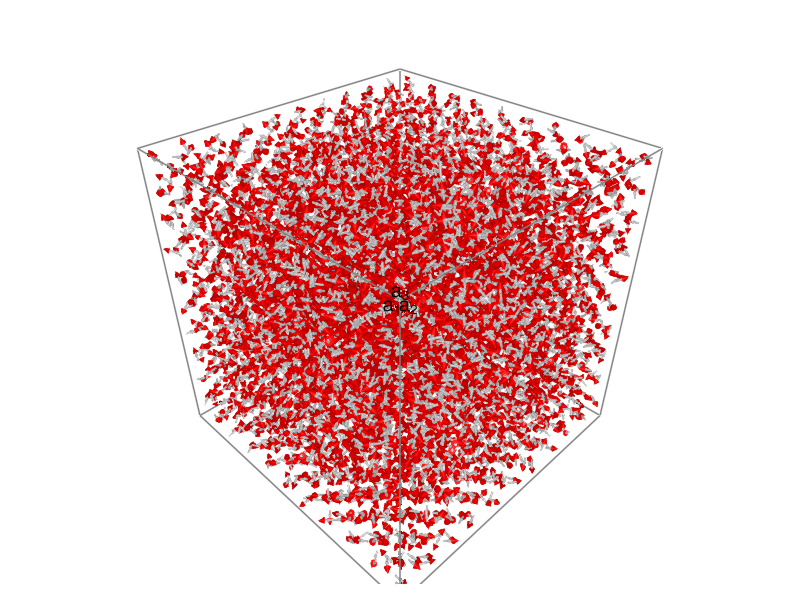

In [9]:
sunmode = :dipole
latsize = (10,10,10)
sys     = System(magxtal, latsize, lhs, sunmode; seed=1)
randomize_spins!(sys)
plot_spins(sys)

Define Exchange Interactions

In [10]:
scaleJ = 0.63
valJ1  = 1.00*scaleJ
set_exchange!(sys, valJ1, Bond(1, 3, [0, 0, 0]));

---
### System thermalization to an ordered, yet finite temperature, state

Define Langevin Integrator and Initialize it

In [11]:
Δt0        = 0.05/abs(scaleJ*S); ## Time steps in Langevin
λ0         = 0.1; ## Langevin damping, usually 0.05 or 0.1 is good.
kT0        = 0.01*abs(scaleJ*S); ## Initialize at some temperature
integrator = Langevin(Δt0; λ=λ0, kT=kT0);

Thermalization
Option 1: Quench the system from infinite temperature to a target temperature.
Note: this may lead to a poorly thermalized sample

In [12]:
quench!(sys, integrator; kTtarget=kT0, nrelax=10000);

Option 2: Anneal (according to a temperature schedule) than dwell once reach base
Note: starting from very high temperature here

In [13]:
# kTs = [abs(scaleJ)*valS*100 * 0.9^k for k in 0:100]
# anneal!(sys,integrator;kTschedule=kTs,ndwell=500)
# dwell!(sys,integrator;kTtarget=kTs[end],ndwell=2000)

Plot the resulting spin system to check ordering in real space

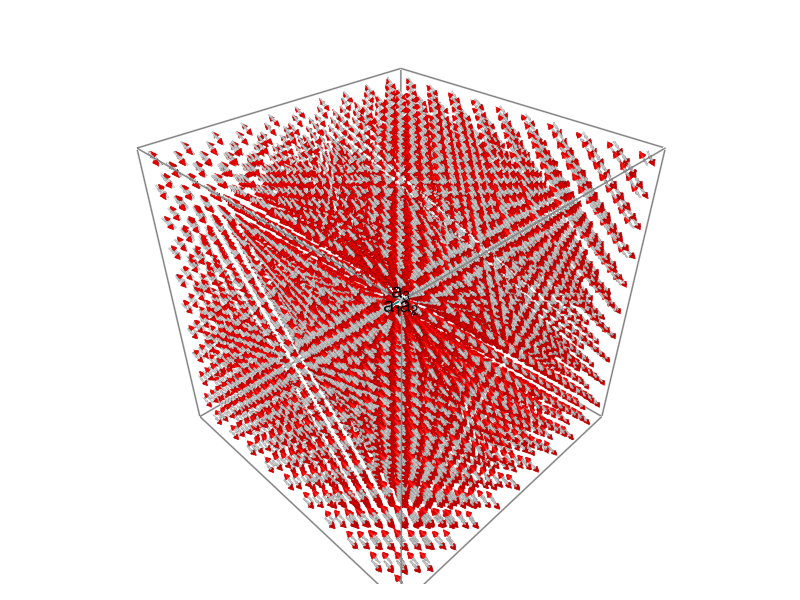

In [14]:
plot_spins(sys)

---
### Calculation of Neutron Scattering Responses

#### Fourier transformed instantaneous two-point correlation functions

Calculate the Instantaneous/Equal-time Structure Factor

In [15]:
eqsf = instant_correlations(sys)

SampledCorrelations (6.262 MiB)
[S(q) | 0 sample]
Lattice: (10, 10, 10)×8
6 correlations in Dipole mode:
╔ ⬤ ⬤ ⬤ Sx
║ ⋅ ⬤ ⬤ Sy
╚ ⋅ ⋅ ⬤ Sz


If desired, add additional samples by decorrelating and then re-calculating the eqsf

In [16]:
nsamples   = 1
ndecorr    = 1000
@time sample_sf!(eqsf, sys, integrator; nsamples=nsamples, ndecorr=ndecorr);

  1.156244 seconds (2.80 M allocations: 179.847 MiB, 6.19% gc time, 54.60% compilation time)


Project onto a constant Q-Slice in momentum space

In [17]:
nQpts  = 200
Qxpts  = range(-10.0, 10.0, length=nQpts)
Qypts  = range(-10.0, 10.0, length=nQpts)
qz     = 1.0
Qpts   = [[qx, qy, qz] for qx in Qxpts, qy in Qypts]
instant_formula = intensity_formula(eqsf, :perp; formfactors)
iq = instant_intensities_interpolated(eqsf, Qpts, instant_formula)

200×200 Matrix{Float64}:
 1.05401e-5  1.89493e-6  7.17608e-6  …  1.90111e-5  8.83246e-6  4.81312e-6
 1.27245e-6  4.16656e-6  1.32437e-5     2.35827e-5  6.55051e-6  3.67265e-6
 3.56074e-6  1.15243e-5  1.33216e-6     9.47778e-6  5.22631e-5  2.49534e-6
 6.46853e-6  7.88419e-6  1.68043e-5     2.97385e-5  1.83969e-5  4.12302e-6
 1.13004e-5  8.44622e-6  2.66351e-5     1.46065e-5  3.16453e-6  2.04334e-5
 3.51864e-5  1.3217e-5   1.18089e-5  …  2.96585e-6  2.15313e-5  1.22067e-5
 4.42617e-6  8.62327e-6  1.59533e-5     5.44148e-5  2.0302e-5   4.49552e-5
 3.30144e-5  1.16325e-5  2.08978e-5     1.43324e-5  9.20018e-6  1.7478e-5
 1.711e-5    1.33635e-6  7.73825e-6     3.01678e-5  1.69971e-5  3.48646e-5
 7.85683e-5  9.38524e-7  1.68567e-5     9.94744e-5  1.36828e-5  5.61047e-5
 ⋮                                   ⋱                          
 3.70698e-5  3.70963e-5  1.43952e-5     9.9352e-6   1.1449e-5   4.53668e-6
 3.74114e-5  5.96263e-5  2.93116e-5     2.71687e-5  5.74343e-5  4.20727e-6
 2.39394e-5

Plot the resulting I(Q)

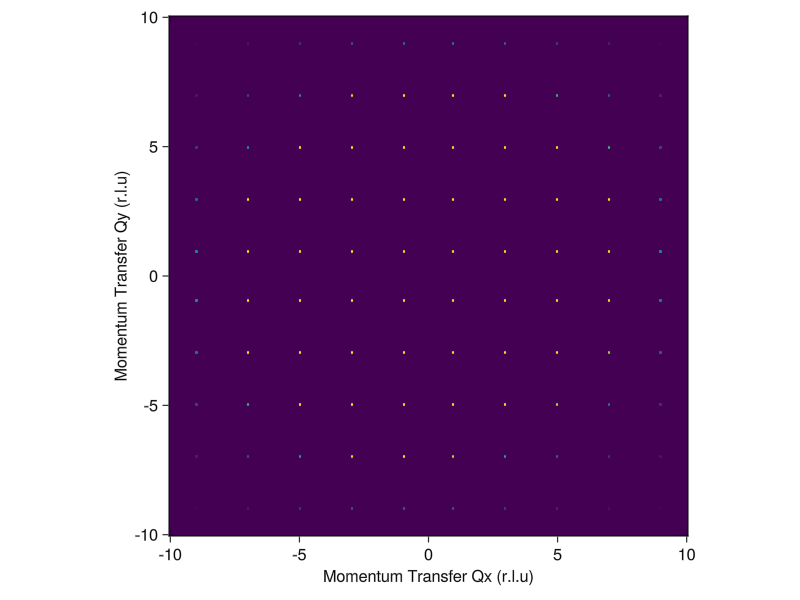

In [18]:
heatmap(Qxpts, Qypts, iq;
    colorrange = (0, maximum(iq)/20),
    axis = (
        xlabel="Momentum Transfer Qx (r.l.u)", xlabelsize=16,
        ylabel="Momentum Transfer Qy (r.l.u)", ylabelsize=16,
        aspect=true,
    )
)

#### Dynamical and energy-integrated two-point correlation functions

Calculate the Time Traces and Fourier Transform: Dynamical Structure Factor (first sample)

In [19]:
ωmax     = 6.0  # Maximum  energy to resolve
nω       = 100  # Number of energies to resolve
sc  = dynamical_correlations(sys; Δt=Δt0, nω=nω, ωmax=ωmax, process_trajectory=:symmetrize)
@time add_sample!(sc, sys) # Add a sample trajectory

  6.072741 seconds (14.33 M allocations: 291.527 MiB, 1.24% gc time, 0.02% compilation time)


If desired, add additional decorrelated samples.

In [20]:
nsamples      = 10
ndecorr       = 1000
@time sample_sf!(sc, sys, integrator; nsamples=nsamples, ndecorr=ndecorr);

Sampling SF: 100%|██████████████████████████████████████| Time: 0:00:57
 63.108072 seconds (143.60 M allocations: 2.868 GiB, 0.49% gc time, 0.24% compilation time)


Can use the Brillouin package for help on determining high symmetry points

In [21]:
kp        = irrfbz_path(227,[[1,0,0], [0,1,0], [0,0,1]])
kpc       = cartesianize(kp)

KPath{3} (6 points, 2 paths, 8 points in paths):
 points: :U => [1.570796, 6.283185, 1.570796]
         :W => [3.141593, 6.283185, 0.0]
         :K => [4.712389, 4.712389, 0.0]
         :Γ => [0.0, 0.0, 0.0]
         :L => [3.141593, 3.141593, 3.141593]
         :X => [0.0, 6.283185, 0.0]
  paths: [:Γ, :X, :U]
         [:K, :Γ, :L, :W, :X]
  basis: [-6.283185, 6.283185, 6.283185]
         [6.283185, -6.283185, 6.283185]
         [6.283185, 6.283185, -6.283185]

Project onto a constant QE-Slice in momentum-energy space.

In [22]:
densQpts  = 50
symQpts   = [[0.75, 0.75, 0.00],  # List of wave vectors that define a path
            [0.00, 0.00, 0.00],
            [0.50, 0.50, 0.50],
            [0.50, 1.00, 0.00],
            [0.00, 1.00, 0.00],
            [0.25, 1.00, 0.25],
            [0.00, 1.00, 0.00],
            [0.00,-4.00, 0.00]]
(Qpts, xticks) = reciprocal_space_path(magxtal, symQpts, densQpts)
formula = intensity_formula(sc, :perp; formfactors, kT=integrator.kT)
iqw = intensities_interpolated(sc, Qpts, formula);

If desired, broaden the sc in energy

In [23]:
η     = 0.1 ## Lorentzian energy broadening parameter
iqwc  = broaden_energy(sc, iqw, (ω, ω₀) -> lorentzian(ω-ω₀, η));

If desired, calculated the energy-integrated structure factor

In [24]:
iqt = instant_intensities_interpolated(sc, Qpts, formula);

Plot the resulting I(Q,W)

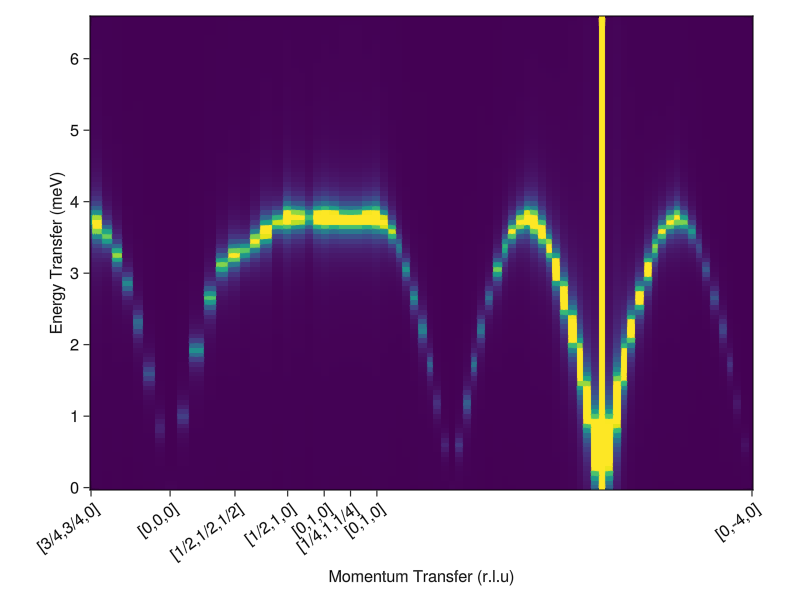

In [25]:
ωs = available_energies(sc)
heatmap(1:size(iqwc, 1), ωs, iqwc;
    colorrange = (0, maximum(iqwc)/20000.0),
    axis = (;
        xlabel="Momentum Transfer (r.l.u)",
        ylabel="Energy Transfer (meV)",
        xticks,
        xticklabelrotation=π/5,
        aspect = 1.4,
    )
)

Projection into a powder-averaged neutron scattering intensity

In [26]:
Qmax       = 3.5
nQpts      = 100
Qpow       = range(0, Qmax, nQpts)
npoints    = 100
pqw = powder_average(sc, Qpow, npoints, formula; η);

Powder Averaging: 100%|█████████████████████████████████| Time: 0:00:13


Plot resulting Ipow(Q,W)

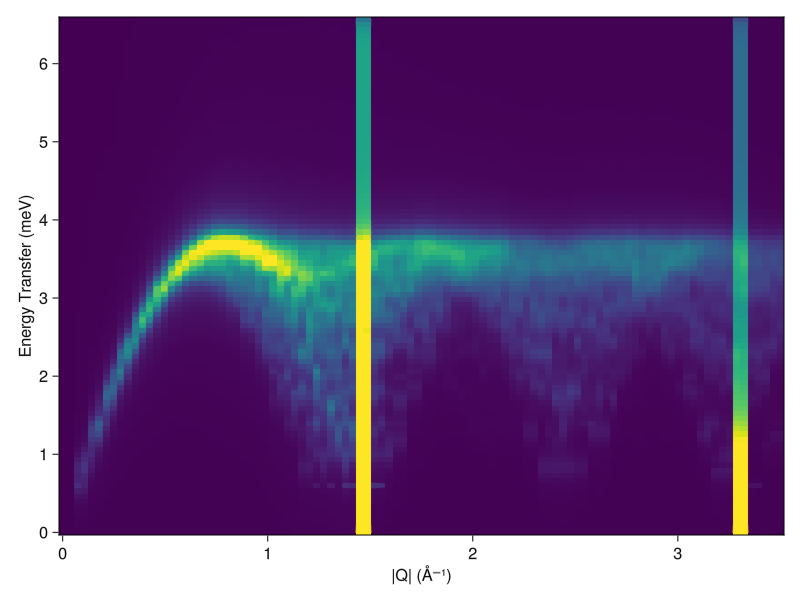

In [27]:
heatmap(Qpow, ωs, pqw;
    axis = (
        xlabel="|Q| (Å⁻¹)",
        ylabel="Energy Transfer (meV)",
        aspect = 1.4,
    ),
    colorrange = (0, 40.0)
)

---
### Calculation of temperature-dependent powder average spectrum

Define a temperature schedule

In [28]:
kTs        = [60 40 25 20 15 12 10 4] * Sunny.meV_per_K
pqw_res    = []
for kT in kTs
    dwell!(sys, integrator; kTtarget=kT, ndwell=1000);
    sc_loc = dynamical_correlations(sys; Δt=Δt0, nω, ωmax, process_trajectory=:symmetrize);
    add_sample!(sc_loc, sys)
    formula = intensity_formula(sc, :perp; formfactors, kT)
    push!(pqw_res, powder_average(sc_loc, Qpow, npoints, formula; η))
end

┌ Warning: Assignment to `formula` in soft scope is ambiguous because a global variable by the same name exists: `formula` will be treated as a new local. Disambiguate by using `local formula` to suppress this warning or `global formula` to assign to the existing global variable.
└ @ ~/Research/SunnyTutorials/Tutorials/CoRh2O4-tutorial.ipynb:7
Powder Averaging: 100%|█████████████████████████████████| Time: 0:00:12
Powder Averaging: 100%|█████████████████████████████████| Time: 0:00:12
Powder Averaging: 100%|█████████████████████████████████| Time: 0:00:12
Powder Averaging: 100%|█████████████████████████████████| Time: 0:00:12
Powder Averaging: 100%|█████████████████████████████████| Time: 0:00:12
Powder Averaging: 100%|█████████████████████████████████| Time: 0:00:12
Powder Averaging: 100%|█████████████████████████████████| Time: 0:00:12
Powder Averaging: 100%|█████████████████████████████████| Time: 0:00:12


Plot the resulting Ipow(Q,W) as a function of temperature,
to compare with Fig.6 of https://arxiv.org/abs/1706.05881

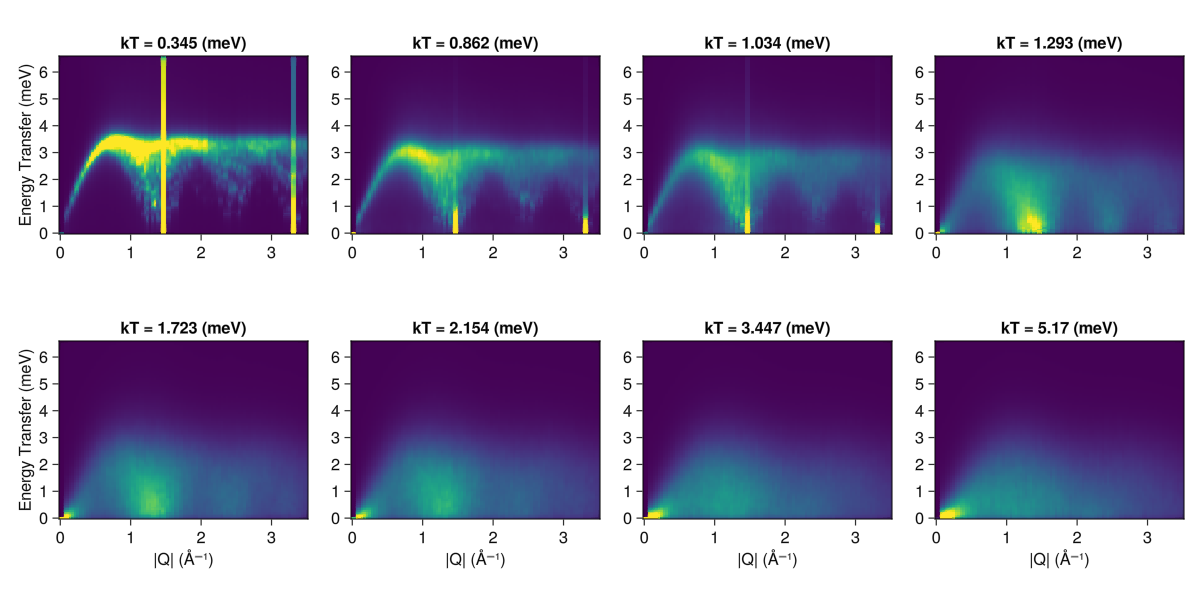

In [29]:
fig = Figure(; resolution=(1200,600))
for i in 1:8
    r, c = fldmod1(i, 4)
    ax = Axis(fig[r, c];
        title = "kT = "*string(round(kTs[9-i], digits=3))*" (meV)",
        xlabel = r == 2 ? "|Q| (Å⁻¹)" : "",
        ylabel = c == 1 ? "Energy Transfer (meV)" : "",
        aspect = 1.4,
    )
    heatmap!(ax, Qpow, ωs, pqw_res[9-i]; colorrange = (0, 20.0))
end
fig

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*